In [2]:
import pylab
import at
from at.load import load_mat
from at import atpass
from at import elements
import numpy as np
import at.plot
import matplotlib.pyplot as plt
from math import pi
import pytest
import scipy
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

Tunes=[0.13289451 0.26929296]
Chrom=[-0.79617305  0.12345348]


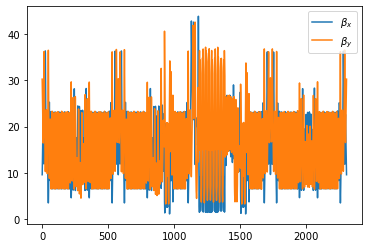

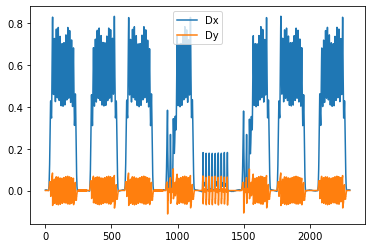

In [2]:
# Lattice creation
%matplotlib inline
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()
lindata0, tune, chrom, lindata = at.linopt(lat, refpts=range(len(lat)), get_chrom=True, twiss_in=None)

print(f"Tunes={tune}")
print(f"Chrom={chrom}")

p1,=plt.plot(lindata.s_pos, lindata.beta[:,0])
p2,=plt.plot(lindata.s_pos, lindata.beta[:,1])
plt.legend([p1,p2],[r'$\beta_x$',r'$\beta_y$'])
plt.figure()
p1,=plt.plot(lindata.s_pos, lindata.dispersion[:,0])
p2,=plt.plot(lindata.s_pos, lindata.dispersion[:,1])
plt.legend([p1,p2],['Dx','Dy'])

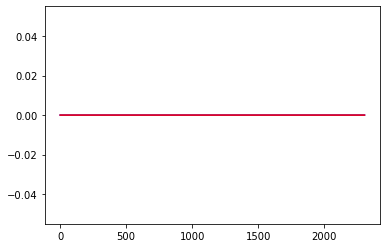

In [3]:
# Plotting orbit
orbit0, orbit = at.find_orbit4(lat, refpts=range(len(lat))) 
x = orbit[:,0]
y = orbit[:,3]
plt.plot(lindata.s_pos, x, 'b-')
plt.plot(lindata.s_pos, y, 'r-')

In [4]:
# Obtaining correctors and BPMs Ids
e_id = 0

bpm_ids = []
cor_ids = []

for r in ring:
    if r.__class__==elements.Monitor: 
        bpm_ids.append(e_id) 
        # print("Monitor:",r.FamName)
    if r.__class__==elements.Corrector: 
        cor_ids.append(e_id) 
        # print("Corrector:",r.FamName)
    e_id += 1

In [5]:
# Calculation of response matrix
dkick = 0.0001
r = []
for cor in cor_ids:
    lat[cor].KickAngle = [dkick, 0.00]
    orbit0, orbit = at.find_orbit4(lat, refpts=range(len(lat))) 
    x = orbit[:,0]
    y = orbit[:,3]
    lat[cor].KickAngle = [0, 0.00]
    r.append(x)
R = np.squeeze(r) / dkick

print(R)

# r = []
# for cor in cor_ids:
#     u=[]
#     for bpm in bpm_ids:
#         u.append((np.sqrt(lindata.beta[bpm,0]*lindata.beta[cor,0])/(2*np.sin(pi*tune[0]))*np.cos((pi*tune[0])-np.abs(-lat[cor].KickAngle))))
#     lat[cor].KickAngle = [0, 0.00]
#     r.append(u)
# print(r)

[[17.40190165 17.40190165 17.78268315 ... 17.42537436 17.39769139
  17.40190165]
 [12.237433   12.237433   12.68668935 ... 12.04486282 12.05299054
  12.237433  ]
 [ 7.67262941  7.67262941  8.66971713 ...  6.72769735  6.84157479
   7.67262941]
 ...
 [17.39783964 17.39783964 17.39555957 ... 17.86251217 17.77660306
  17.39783964]
 [17.31617464 17.31617464 17.40277024 ... 17.67628876 17.60429519
  17.31617464]
 [11.50847142 11.50847142 11.84659377 ... 11.42457412 11.41938848
  11.50847142]]


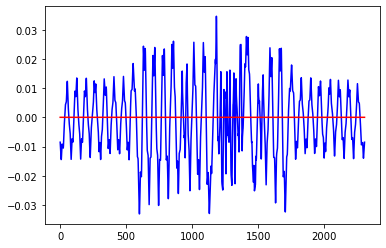

In [6]:
# Adding error
quad_ids = at.get_refpts(lat, elements.Quadrupole)
at.shift_elem(lat[quad_ids[0]], deltax=0.01, deltaz=0.0, relative=False)

orbit0, orbit = at.find_orbit4(lat, refpts=range(len(lat))) 
x = orbit[:,0]
y = orbit[:,3]
plt.plot(lindata.s_pos, x, 'b-')
plt.plot(lindata.s_pos, y, 'r-')

In [7]:
# Solve system with SVD
def solve_svd(A, b, k):
    U, s, VT = np.linalg.svd(A, full_matrices=True)
    c = np.dot((U[:, :k]).T, b) 
    w = np.dot(np.diag(1/s)[:k, :k], c) 
    x = np.dot((VT[:k, :]).T, w) 
    return x

cs = solve_svd(R.T, -x, 80) # 80 most important and independent singular values

In [8]:
# Changing correctors kick angle
i=0
for cor in cor_ids:   
    lat[cor].KickAngle  = [cs[i], 0]
    i = i + 1

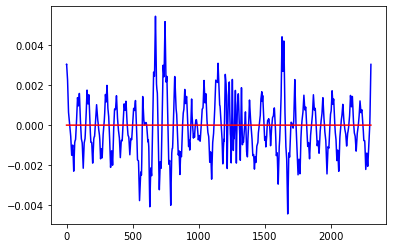

In [9]:
# Plotting final result
orbit0, orbit = at.find_orbit4(lat, refpts=range(len(lat))) 
x = orbit[:,0]
y = orbit[:,3]
plt.plot(lindata.s_pos, x, 'b-')
plt.plot(lindata.s_pos, y, 'r-')